# **Tutorial 6: Spectral Analysis of Paleoclimate Data**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Yosmely Bermúdez, Dionessa Biton, Katrina Dobson, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Zahra Khodakaramimaghsoud, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

## **Code and Data Sources**

Code for this tutorial is based on existing notebooks from LinkedEarth for [spectral analysis](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L2_spectral_analysis.ipynb) and [wavelet analysis](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L2_wavelet_analysis.ipynb).

Data from the following sources are used in this tutorial:

*   Lisiecki, L. E., and Raymo, M. E. (2005), A Pliocene-Pleistocene stack of 57 globally distributed benthic δ<sup>18</sup>O records, Paleoceanography, 20, PA1003,  https://doi.org/10.1029/2004PA001071.

















# **Tutorial Objectives**

In this tutorial, you will manipulate paleoclimate proxy datasets using previously learned computational tools, and apply spectral analysis to further interpret the data.


By the end of this tutorial you will be able to:

*   Interpret the LR04 benthic δ<sup>18</sup>O curve and how it records temperature
*   Perform various spectral analysis methods to assess dominant spectral powers in the LR04 data
*   Interpret variations in glacial-interglacial cycles recorded by the LR04 δ<sup>18</sup>O record




In [ ]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video


# Setup

In [ ]:
# # Install libraries
# !pip install pooch
# !pip install pandas
# !pip install matplotlib

# !pip install cartopy
# !pip install pyleoclim

In [1]:
import pooch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy
import pyleoclim as pyleo
# import os
# import requests


# **Section 1: Plotting the LR04 δ<sup>18</sup>O benthic stack**

We will be analyzing a δ<sup>18</sup>O data from [Lisiecki, L. E., and Raymo, M. E. (2005)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071), A Pliocene-Pleistocene stack of 57 globally distributed records of δ<sup>18</sup>O from benthic foraminifera. As we learned from the introductory video, δ<sup>18</sup>O of foraminifera records temperature due to difference in the isotopic composition of the ocean during glacial and interglacial periods. The δ<sup>18</sup>O of the ocean (and forams) is more depleted during interglacials and more enriched during glacials.

Let's start by importing the data:

In [2]:
# Donwload the data
url_LR04='https://raw.githubusercontent.com/LinkedEarth/PyleoTutorials/main/data/LR04.csv'
lr04_data = pd.read_csv(pooch.retrieve(url_LR04,known_hash=None), skiprows=4)
lr04_data.head()

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03


We can now create a `Series` object containing the data:

In [3]:
ts_lr04 = pyleo.Series(
    time=lr04_data['Time (ka)'],
    value=lr04_data['Benthic d18O (per mil)  '],
    time_name='Age',
    time_unit='kyr BP',
    value_name='Benthic d18O (per mil)',
    value_unit=u'\u2030',
    label='LR04'
)

Time axis values sorted in ascending order


This record spans the past 5 million years (5,000 kyr), but we're going to focus in on the past 1 million years (1,000 kyr), so let's create a time slice of just this time period, and plot the time series.

<Axes: xlabel='Age [kyr BP]', ylabel='Benthic d18O (per mil) [‰]'>

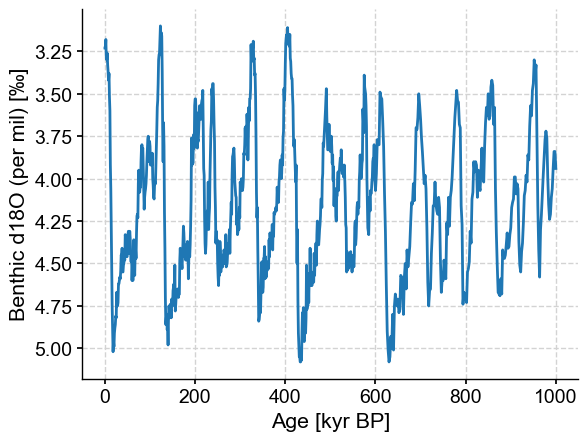

In [4]:
lr04_slice = ts_lr04.slice([0,1000])
fig,ax=plt.subplots() # assign a new plot axis
lr04_slice.plot(ax=ax,legend=False, invert_yaxis=True)

What patterns do you observe in the record? 


*   Does the amplitude of the glacial-interglacial cycles vary over time?
*   At what frequency do these glacial-interglacial cycles occur?

We can visually assess the duration of each cycle by just looking at the time series but to better assess the dominant temporal patterns in this record, we can use spectral analysis. As we learned in the introductory video, spectral analysis is a useful data analysis tool in paleoclimate because it allows us to discover underlying periodicities in time series data and can help to establish quantitative relationships between forcing and climate change.

Let's explore various spectral analysis methods and apply them to the LR04 record to interpret changes in the frequency of glacial-interglacial cycles.


# **Section 2: Spectral analysis of the LRO4 δ<sup>18</sup>O benthic stack**

Pyleoclim enables five spectral analysis methods:

*   **Basic Periodogram**, which uses a Fourier transform. The method has various windowing available to reduce variance.
*  **Welch's periodogram**, a variant of the basic periodogram, which uses Welch's method of overlapping segments. The periodogram is computed on each segment and averaged together
*   **Multi-taper method (MTM)**, which attempts to reduce the variance of spectral estimates by using a small set of tapers rather than the unique data taper or spectral window
*   **Lomb-Scargle periodogram**, an inverse approach designed for unevenly-spaced datasets. Several windows are available and Welch's segmentation can also be used with this method.
*   **Weighted wavelet Z-transform**, a wavelet-based method also made for unevenly-spaced datasets.


All of these methods are available through Series.spectral by changing the method argument. In this tutorial, we'll focus on Lomb-Scargle and Weighted wavelet Z-transform in more detail. For additional information on the other methods, refer to this notebook from [Pyleoclim](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L2_spectral_analysis.ipynb).

The Lomb-Scargle periodogram is the default method in Pyleoclimmeant and is meant to work with unevenly-spaced timeseries. It is a good choice for many applications: (1) it seems to give consistent results over parameter ranges, (2) doesn't require interpolation, limiting timeseries manipulation, and (3) it is fairly fast to compute. The spectral density can be computed from the weighted wavelet Z transform wavelet method in one of two ways:
- calculate the scalogram separately and then compute the periodogram via time integration
- use the method through the `spectral()` method of the Series class.



In [5]:
#Standardize and interpolate the data
lr04_stnd = lr04_slice.interp(step=0.5).standardize() # save it for future use

In [6]:
#Calculate the Lomb-Scargle spectral analysis
lr04_ls = lr04_stnd.spectral(method='lomb_scargle', freq_method='lomb_scargle')

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyrs]', ylabel='PSD'>)

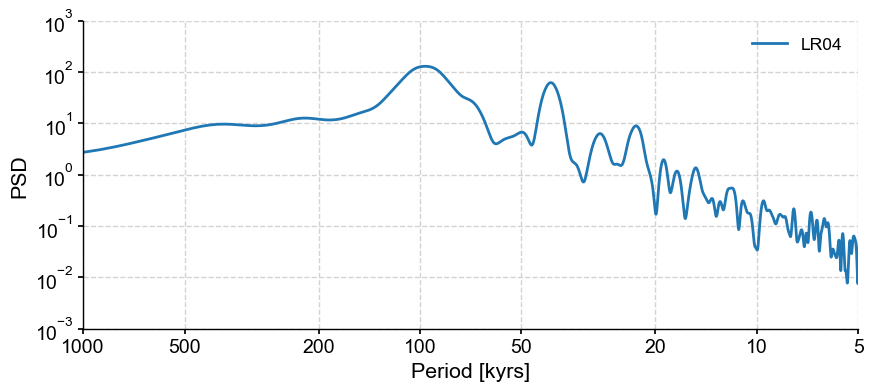

In [7]:
#Plot Lomb-Scargle results
lr04_ls.plot(xlim=[1000, 5],ylim=[0.001, 1000])

In [8]:
#Calculate the Weighted wavelet Z-transform spectral analysis
lr04_wwz = lr04_stnd.spectral(method='wwz')

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyrs]', ylabel='PSD'>)

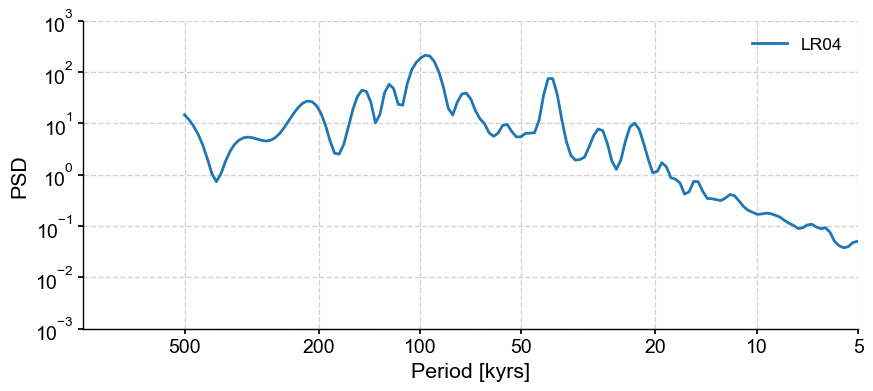

In [9]:
#Plot Weighted wavelet Z-transform results
lr04_wwz.plot(xlim=[1000, 5],ylim=[0.001, 1000])

Performing both spectral analysis methods involved three commands: 


1.   Standardizing and intrpolating the data 
2.   Computing the spectrum
3.   Storing this output in a variable and plot the results


There are few peak that seem more dominant than others, but which of these peaks are significant? To figure that out, we can use the method `signif_test`.  Pyleoclim tests against an AR(1) benchmark, simulating surrogates of the time series. The test with `number=50`, the code would take ~20 minutes to run, so just as an example, we will use `number=5`, which should only take ~2 minutes to run.

>_**Chi comment**_ I am a bit confused about this number =50, is this the significance level? Is this number = 5 equivalent to qs number in lr04_s.standardize().spectral().signif_test(qs=[0.90,0.95,0.99]).plot() as in PyleoTutorial L2?

## ohad comment: it's not qs. number is "Number of surrogates to generate for significance analysis based on simulations. The default is 200." I don't think it will anything to the students and we should remove it. just say that they should use number=5 to make it run faster. and link the library documation. https://pyleoclim-util.readthedocs.io/en/v0.8.0/core/api.html#pyleoclim.core.scalograms.Scalogram.signif_test


In [10]:
lr04_wwz_sig = lr04_wwz.signif_test(number=5)

Performing spectral analysis on individual series: 100%|█████████████████████████████████| 5/5 [00:48<00:00,  9.72s/it]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyrs]', ylabel='PSD'>)

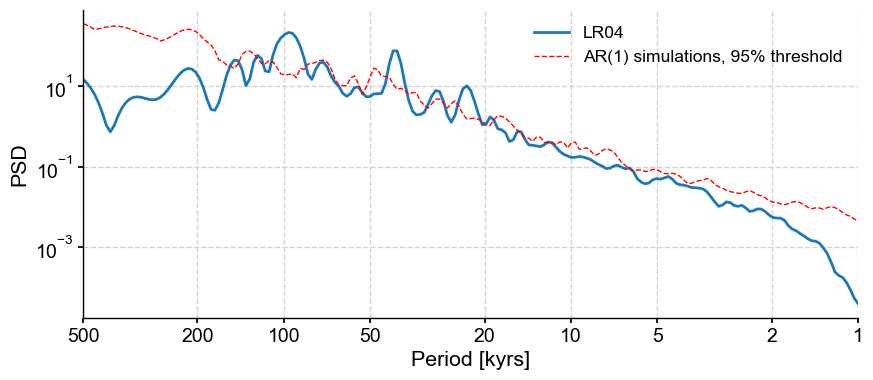

In [11]:
lr04_wwz_sig.plot(xlabel='Period [kyrs]')

The peaks above the 95% treshold (the red dashed line) are significant. If we were to use `number=50` instead, the AR(1) simulations and 95% threshold would be more precise. Rather than running this code with `number=50`, we can download the results from a previously run `signif_test` with `number=50`: 

In [12]:
# fname = 'lr04_wwz_sig.csv'
url_lr04_n50 = "https://osf.io/wm6p8/download/"
lr04_wwz_sig_results = pd.read_csv(pooch.retrieve(url_lr04_n50,known_hash=None))

The data we just downloaded and stored in the variable `lr04_wwz_sig_results` contains the significant values of the spectral analysis of the LR04 data. We can now create the same plot of spectral power, but with only the significant values. 

NOTE: For this figure, we will plot the x-axis a bit differently. In the previous plot, the x-axis was the "period" but this time the x-axis will be "frequency", which is the inverse of the period. Both period and frequency represent the same time intervals, just in different units.

Text(0, 0.5, 'Spectra Amplitude')

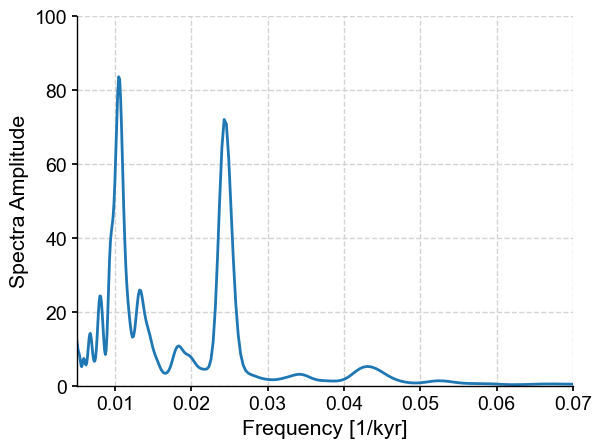

In [13]:
plt.plot(lr04_wwz_sig_results['Frequency'],lr04_wwz_sig_results['Amplitude'])
plt.xlim([0.005, 0.07])
plt.ylim([0, 100])
plt.xlabel('Frequency [1/kyr]')
plt.ylabel('Spectra Amplitude')

The largest spectral powers in the data occur at a frequencies of ~0.01 and ~0.025, as well as a smaller peak at ~0.042, which correspond to 100 kyr, 23 kyr, and 40 kyr, respectively. Do those periodicities sound familiar? 

These are the cycles of **eccentricity, obliquity and precession**, which control variations in solar insolation and the glacial-interglacial cycles! The presence of spectral powers in the LR04 data at the eccentricity, obliquity and precession frequencies highlight the influence of orbital forcings on glacial-interglacial cycles.


## Wavelet Analysis

Another related tool we can use to learn more about the climate variations recorded is the data is wavelet analysis. This method allows us to  "unfold" a spectrum and look at its evolution over time. In other words, wavelet analysis can help us determine changes in the spectral power over time. More additional details about wavelet analysis, refer to [this guide](https://paos.colorado.edu/research/wavelets/bams_79_01_0061.pdf).

There are several ways to access that functionality in Pyleoclim, but here we use summary_plot, which stacks together the timeseries itself, its scalogram (a plot of the magnitude of the wavelet power), and the power spectral density (PSD) obtained from summing the wavelet coefficients over time.


In [14]:
scal = lr04_stnd.wavelet()

(<Figure size 800x1000 with 4 Axes>,
 {'ts': <Axes: xlabel='Age [kyr BP]', ylabel='Benthic d18O (per mil) [‰]'>,
  'scal': <Axes: xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>,
  'psd': <Axes: xlabel='Amplitude'>,
  'cb': <Axes: xlabel='cwt Amplitude'>})

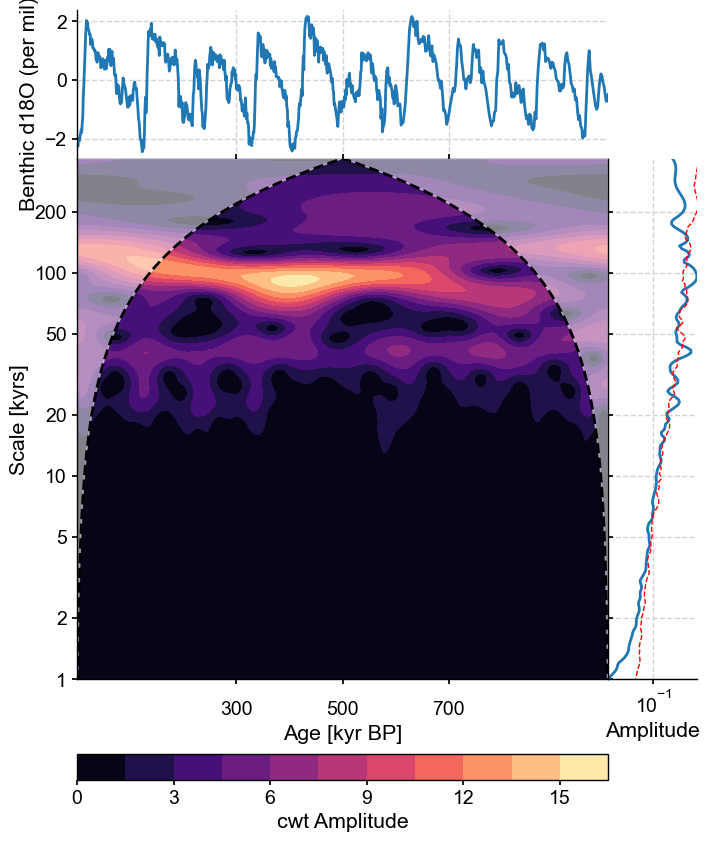

In [15]:
lr04_stnd.summary_plot(psd=lr04_wwz_sig,scalogram=scal,time_lim=[0,1000],psd_label='Amplitude')

In this wavelet spectrum, the age of the record is on the x-axis, the period is on the y-axis, and the color represents the amplitude of that power spectrum, with yellow indicating a stronger power spectrum and purple indicating a weaker power spectrum. The time series on top is the original LR04 d18O data, and the time series on the right is the spectral analysis and significant test figure we looked at earlier.

As we saw in the spectral analysis above, the 100 kyr and 40 kyr period are the most dominant. Here, we further see that over the past 1 million years, the 100 kyr cycle is the strongest (as seen by the yellow color at the 100 kyr scale), followed by the 40 kyr cycle (as seen by the light purple color at the 40 kyr scale). You may notice an absence of much color at the 23 kyr scale. What does this suggest about the influence of precession on glacial-interglacial cycles on this timescale?

In [16]:
# to_remove explanation  

"""
The absence of much color at the 23 kyr scale in the wavelet spectrum suggests that the influence of precession on glacial-interglacial cycles is less significant on this timescale. In other words, these cycles are not strongly modulated by the precession cycle, which typically occurs every 23,000 years.
"""

'\nThe absence of much color at the 23 kyr scale in the wavelet spectrum suggests that the influence of precession on glacial-interglacial cycles is less significant on this timescale. In other words, these cycles are not strongly modulated by the precession cycle, which typically occurs every 23,000 years.\n'

# **Summary**
This tutorial equips you with the skills to handle paleoclimate proxy datasets using computational tools, with an emphasis on applying spectral and wavelet analysis to the LR04 benthic δ<sup>18</sup>O curve, a key indicator of temperature changes. You will be introduced to several spectral analysis methods and gain practical experience in identifying dominant spectral powers in the LR04 data. You will also learn to recognize variations in glacial-interglacial cycles, using tools like wavelet analysis to track spectral power changes over time. Pyleoclim's features, such as summary_plot, will be utilized for this purpose. The tutorial focuses on certain techniques like the Lomb-Scargle and Weighted wavelet Z-transform. By the end, you will be able to determine the influence of various periods, like the 100 kyr and 40 kyr, on glacial-interglacial cycles and interpret the significance of these cycles in climate change.